### Library

In [1]:
import os
import time
import random
import timm
import torch
import cv2
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [2]:
def random_seed(SEED=42):
    # SEED = 42 # default
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

random_seed()

### Load Data

In [3]:
test_df = pd.read_csv("../data/sample_submission.csv")
test_df

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,0
4,00901f504008d884.jpg,0
...,...,...
3135,ffb4b6f619fb60ea.jpg,0
3136,ffb54299b1ad4159.jpg,0
3137,ffc2c91dff8cf2c0.jpg,0
3138,ffc4e330a5353a2a.jpg,0


In [4]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# hist plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, 
              color1='skyblue', color2='salmon', label1=None, label2=None, 
              title=None, density=False):
    plt.figure(figsize=figsize)
    
    stat_mode = 'density' if density else 'count'

    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, 
                 stat=stat_mode, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None:
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, 
                     stat=stat_mode, label=label2 if label2 else 'Group 2')
        plt.legend()

    plt.title(title if title else f'{col} Distribution ({"Density" if density else "Count"} Histogram + KDE)')
    plt.xlabel(col)
    plt.ylabel("Density" if density else "Count")
    plt.show()

# bar plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# box_plot
def box_plot(df1, col, df2=None, figsize=(8, 6), color1='skyblue', color2='salmon', title=None):
    plt.figure(figsize=figsize)

    if df2 is None:
        # 단일 데이터프레임 boxplot
        sns.boxplot(y=df1[col], color=color1)  # 개별일 때는 color1 (기본값 skyblue)
        plt.ylabel(col)
        plt.title(title if title else f'{col} (Box Plot)')
    else:
        # 두 데이터프레임 비교 boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(y=df1[col], color=color1)  # 첫 번째 그룹은 color1
        plt.ylabel(col)
        plt.title(f'Group 1 - {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df2[col], color=color2)  # 두 번째 그룹은 color2
        plt.ylabel(col)
        plt.title(f'Group 2 - {col}')

        plt.suptitle(title if title else f'{col} Comparison (Box Plot)', fontsize=12)

    plt.show()

# heatmap
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

In [5]:
test_path = "../data/test/"
resolution_stats = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_name = row['ID']  # ID 컬럼에서 이미지 파일명
    img_path = os.path.join(test_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"[로드 실패] {img_path}")
        continue
    
    height, width = img_cv.shape
    resolution_stats.append({
        "ID": img_name,
        "target": row["target"],
        "width": width,
        "height": height,
        "aspect_ratio": width / height
    })

resolution_df = pd.DataFrame(resolution_stats)
resolution_df

  0%|          | 0/3140 [00:00<?, ?it/s]

100%|██████████| 3140/3140 [00:03<00:00, 1022.45it/s]


,ID,target,width,height,aspect_ratio
0,0008fdb22ddce0ce.jpg,0,443,591,0.749577
1,00091bffdffd83de.jpg,0,591,443,1.334086
2,00396fbc1f6cc21d.jpg,0,408,642,0.635514
3,00471f8038d9c4b6.jpg,0,591,443,1.334086
4,00901f504008d884.jpg,0,443,591,0.749577
...,...,...,...,...,...
3135,ffb4b6f619fb60ea.jpg,0,591,443,1.334086
3136,ffb54299b1ad4159.jpg,0,591,443,1.334086
3137,ffc2c91dff8cf2c0.jpg,0,639,409,1.562347
3138,ffc4e330a5353a2a.jpg,0,591,443,1.334086


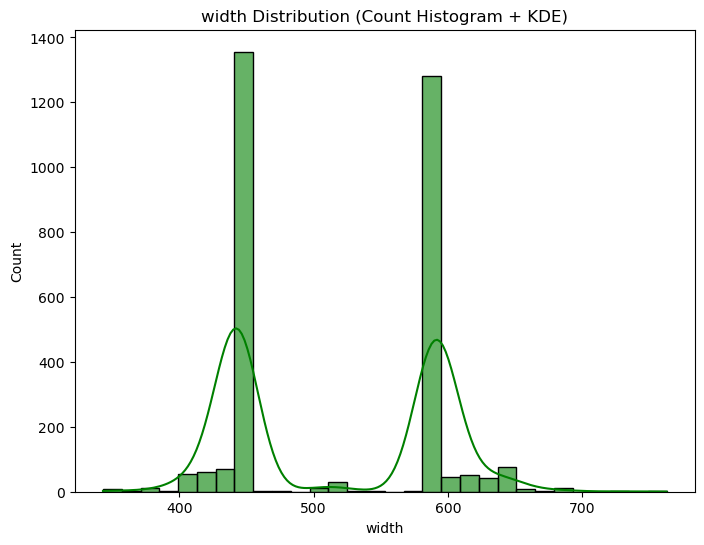

,width,height,aspect_ratio
count,3140.000000,3140.000000,3140.000000
mean,517.085032,518.556369,1.045708
std,79.846556,79.803967,0.317740
min,343.000000,343.000000,0.449541
25%,443.000000,443.000000,0.749577
50%,489.000000,535.500000,0.914688
75%,591.000000,591.000000,1.334086
max,763.000000,763.000000,2.224490


In [6]:
hist_plot(resolution_df, col='width', color1='Green')
resolution_df[['width', 'height', 'aspect_ratio']].describe()

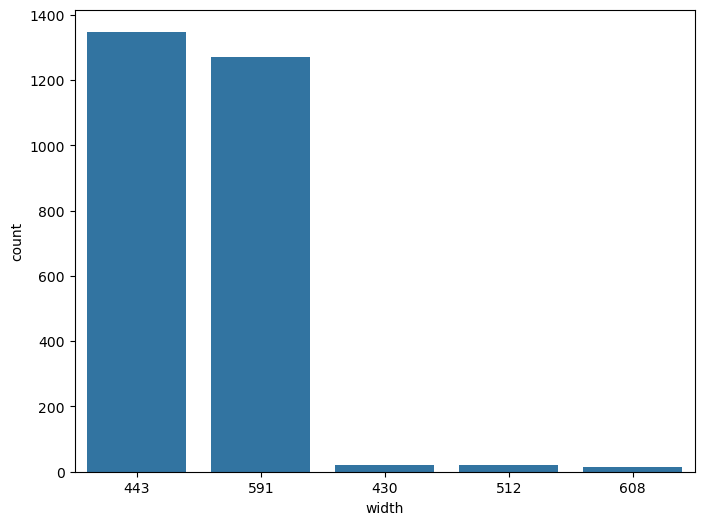

In [14]:
img_size_valuecnt = resolution_df['width'].value_counts().reset_index()
img_size_valuecnt.columns = ['width', 'count']  # 컬럼명 명확히
top5_img_size = img_size_valuecnt.head()

plt.figure(figsize=(8, 6))
sns.barplot(data=top5_img_size, x='width', y='count', order=top5_img_size['width'])
plt.show()

In [ ]:
def random_sample_image(image_dir, n_samples=5, title="Random Samples", figsize=(15, 3), cmap="gray"):

    img_names = os.listdir(image_dir)
    samples = random.sample(img_names, n_samples)

    fig, axes = plt.subplots(1, n_samples, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    for i, img_name in enumerate(samples):
        img_path = os.path.join(image_dir, img_name)
        img = np.array(Image.open(img_path))
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(img_name)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

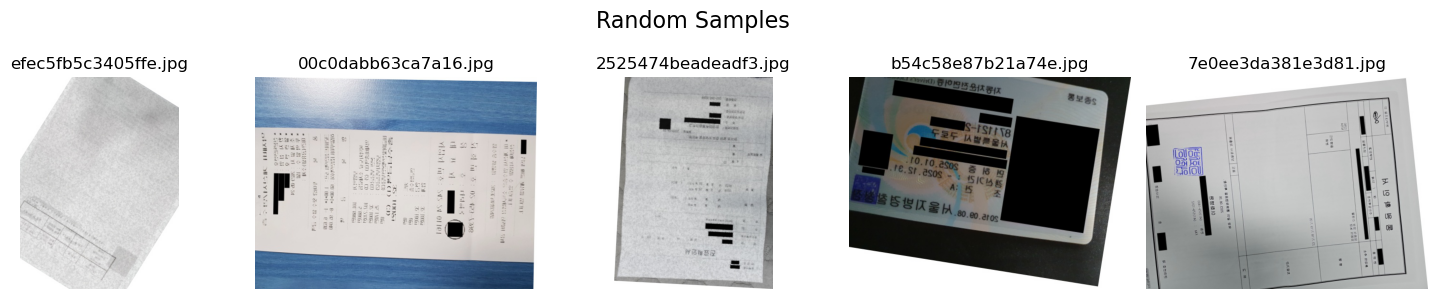

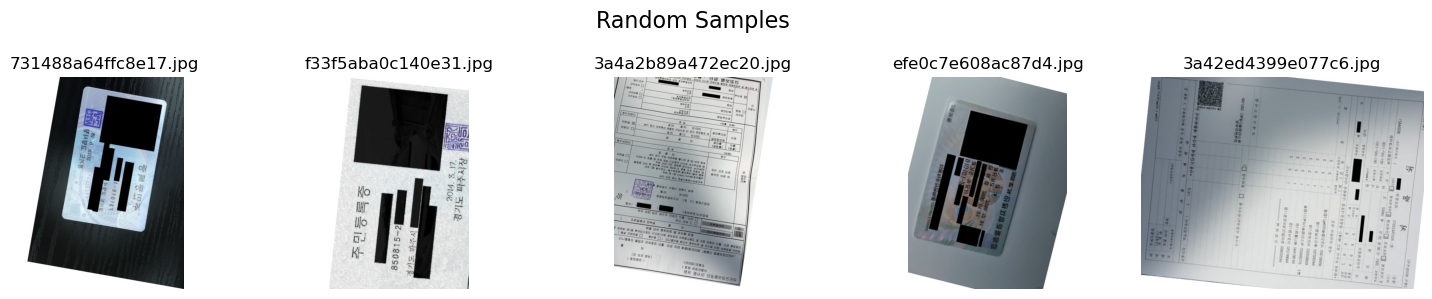

In [ ]:
n_samples = 5  # 보고 싶은 샘플 수
test_path = "../data/test"

random_sample_image(test_path, n_samples)
random_sample_image(test_path, n_samples)

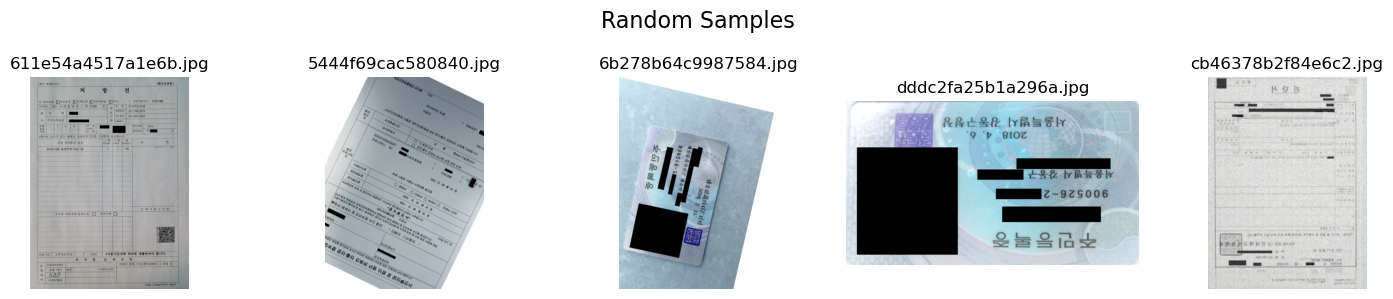

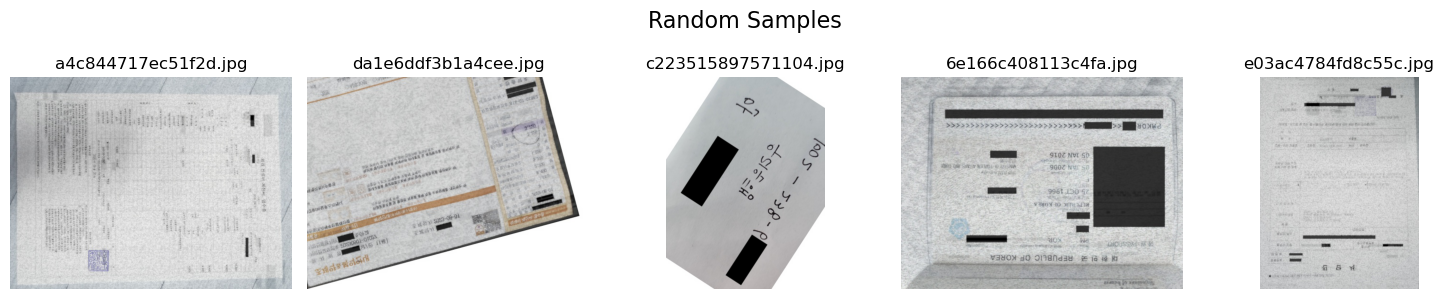

In [ ]:
random_sample_image(test_path, n_samples)
random_sample_image(test_path, n_samples)

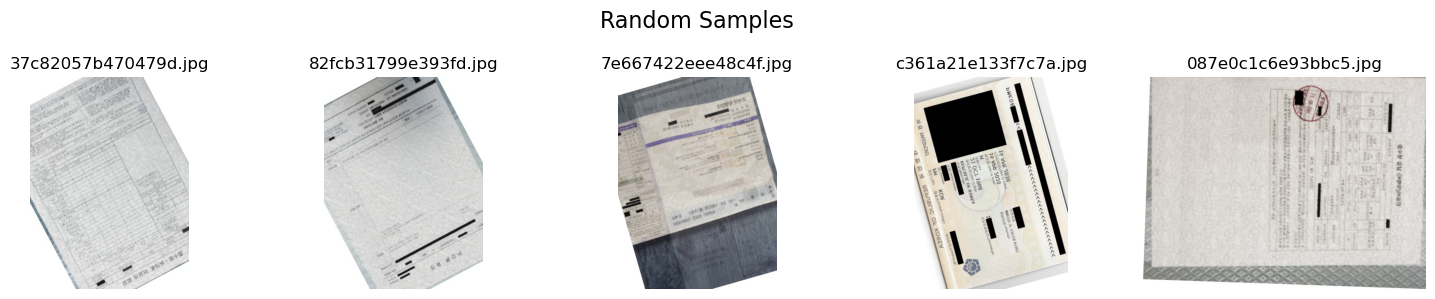

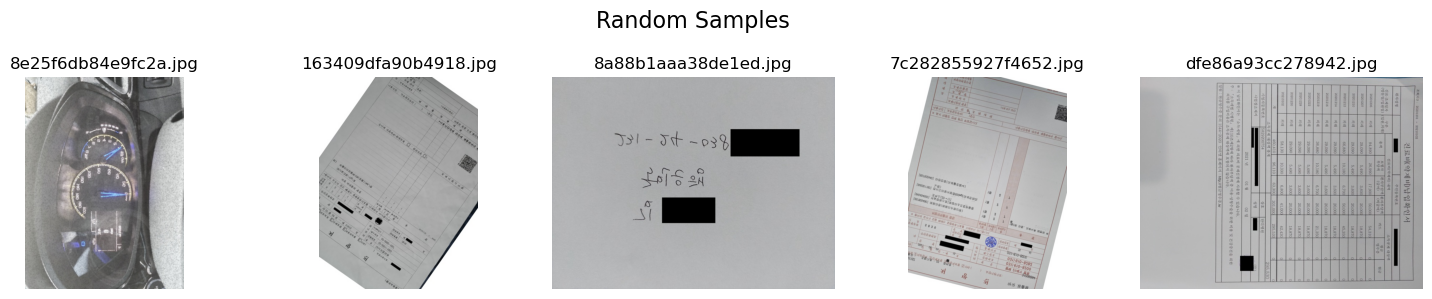

In [ ]:
random_sample_image(test_path, n_samples)
random_sample_image(test_path, n_samples)